## Раздел II. Обогащение данных (продожение)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from datetime import datetime

In [2]:
# загрузим рабочий набор из предыдущего этапа 
orders = pd.read_csv('orders_2-1.csv', low_memory=False)

In [4]:
# импортируем из вспомогателього модуля 'my_utils' класс для работы с orders
from my_utils import Order

# создадим объект
obj_orders = Order(orders)

### е). добавить признак - расстояние до покупателя
 
__CUST_DIST__ - рассчитывается, через расстояние между широтой(__lat__) и долготой(__long__) для zip кода из адреса пркупателя и такими же параметрами продавца

#### проведем подготовку поля 'CUST_ZIP_C'

In [5]:
orders[pd.isnull(orders.CUST_ZIP_C)].shape[0]    # кол-во пустых zip-кодов

643

In [6]:
# удалим строки с пустым zip-кодом
orders.dropna(axis=0, subset=['CUST_ZIP_C'], inplace=True)

In [7]:
# подсчитаем кол-во различных длин zip-кодов
group_by_zip = orders.groupby(orders.apply(lambda x: len(x.CUST_ZIP_C), axis=1))

In [8]:
group_by_zip.SA_HDR_TIC.agg('count')

4          1
5     174142
6        389
8         12
9         33
10      4039
Name: SA_HDR_TIC, dtype: int64

In [9]:
# zip-код д/б длиной 5, поэтому удалим все, которые < 5 и обрежем справа все,которые > 5
orders = orders[orders.apply(lambda x: len(x.CUST_ZIP_C) >=5, axis=1)]

In [10]:
orders.CUST_ZIP_C = orders.loc[:, 'CUST_ZIP_C'].map(lambda x: x[:5])

/Users/sergey/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


#### Вычислим расстояние до торговой точки покупателя

In [11]:
# загрузим вспомогательный файл (взят из http://federalgovernmentzipcodes.us)
zip_codes = pd.read_csv('us_zip.csv', dtype={'ZIP': 'object'})
zip_codes.head()

,ZIP,LAT,LNG
0,00601,18.180555,-66.749961
1,00602,18.361945,-67.175597
2,00603,18.455183,-67.119887
3,00606,18.158345,-66.932911
4,00610,18.295366,-67.125135


In [12]:
# zip-код продавца
JFS_ZIP = '19154'

In [13]:
# координаты продавца (tuple)
JFS_LOC = (float(zip_codes.LAT[zip_codes.ZIP == JFS_ZIP]), 
           float(zip_codes.LNG[zip_codes.ZIP == JFS_ZIP]))
print(JFS_LOC)

(40.096483, -74.98321700000001)


In [14]:
# сформируем парные координаты для расчета расстояния в вспомогательном датафрейме
zip_codes['LOC'] = zip(zip_codes.LAT, zip_codes.LNG)

In [15]:
zip_codes.head(4)

,ZIP,LAT,LNG,LOC
0,00601,18.180555,-66.749961,"(18.180555, -66.749961)"
1,00602,18.361945,-67.175597,"(18.361945, -67.175597)"
2,00603,18.455183,-67.119887,"(18.455183, -67.119887)"
3,00606,18.158345,-66.932911,"(18.158345, -66.932911)"


In [16]:
# воспользуемся библиотекой `geopy`
from geopy.distance import vincenty

# посчитаем расстояния (в км.)
zip_codes['CUST_DIST'] = map(lambda x: int(vincenty(JFS_LOC, x).km), zip_codes.LOC)

In [17]:
zip_codes.head(4)

,ZIP,LAT,LNG,LOC,CUST_DIST
0,00601,18.180555,-66.749961,"(18.180555, -66.749961)",2554
1,00602,18.361945,-67.175597,"(18.361945, -67.175597)",2523
2,00603,18.455183,-67.119887,"(18.455183, -67.119887)",2514
3,00606,18.158345,-66.932911,"(18.158345, -66.932911)",2551


In [18]:
# присоединим столбец 'CUST_DIST' к основному набору
orders = pd.merge(orders,zip_codes[['ZIP', 'CUST_DIST']], 
                  left_on='CUST_ZIP_C', right_on='ZIP', how='left')
orders.drop('ZIP', axis=1, inplace=True)

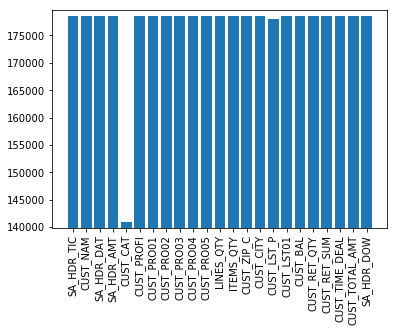

In [22]:
# визуализируем частотность
obj_orders.futures_dist(y_max=1000, y_min=1000)

In [19]:
# сохраним рабочий набор для следующего этапа
orders.to_csv('orders_3.csv', index=False)